# Clasificación de propinas en taxis de Nueva York

En esta notebook se clasificarán con algoritmos de machine learning de Spark si un viaje en Nueva York en taxi terminará con propina o no para el taxista. El dataset cuenta con más de 55 millones de registros y 13 columnas.
* *unique_ke*y: ID único del trayecto,
* *taxi_id*: ID del taxi en el trayecto,
* *trip_start_timestamp*: Fecha en la que el trayecto comenzó,
* *trip_seconds*: Duración del trayecto en segundos,
* *trip_miles*: Millas recorridas en el trayecto,
* *pickup_community_area*: Área donde comenzó el trayecto,
* *dropoff_community_area*: Área de la comunidad donde terminó el trayecto,
* *fare*: Costo del trayecto sin sumar peajes (tolls) ni gastos extra (extras),
* *tip*: Si se ha dado propina o no (target),
* *tolls*: Peaje que se ha tenido que pagar en el viaje,
* *extras*: Gastos extra en el viaje,
* *payment_type*: tipo de pago realizado.

El dataset cuenta con datos desde el 2013 al 2021.

## Imports y carga del dataframe

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col, year, hour, when


In [0]:
df = (
    spark
    .read
    .format('parquet')
    .load('s3a://mc1-m13-capstone-data/taxi-tips/')
)

# Se imprime el esquema para ver que se haya cargado todo bien.
df.printSchema()

root
 |-- unique_key: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: boolean (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)



## Análisis Exploratorio de Datos

In [0]:
# Se ve el tamaño del dataframe
registros = df.count()
print(f'Registros: {registros}')
columnas = len(df.columns)
print(f'Columnas: {columnas}')

Registros: 55759721
Columnas: 13


In [0]:
df.show() # Se previsualiza el dataframe

+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----+-----+-----+------+------------+--------------------+
|          unique_key|             taxi_id|trip_start_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area| fare|  tip|tolls|extras|payment_type|             company|
+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----+-----+-----+------+------------+--------------------+
|27f58235ca5cf93f9...|4de82fc17cb23f745...| 2013-04-17 00:45:00|         300|       1.8|                   22|                    22| 6.85|false|  0.0|   0.0|   No Charge|Dispatch Taxi Aff...|
|4e09abcd5007b4f52...|fdde0d46da2b9e51a...| 2015-01-31 14:15:00|         300|       1.6|                   32|                    33| 6.65|false|  0.0|   1.0|   No Charge|Northwest Managem...|
|b359bf49f427baf94...|6e009c7c3937a

In [0]:
# Se separan columnas categóricas de numéricas.
cat_cols = [
  'payment_type', 
  'company'
]
num_cols = [
  'trip_seconds', 
  'trip_miles', 
  'pickup_community_area', 
  'dropoff_community_area', 
  'fare', 
  'tolls', 
  'extras'
]

#### Análisis para variables numéricas

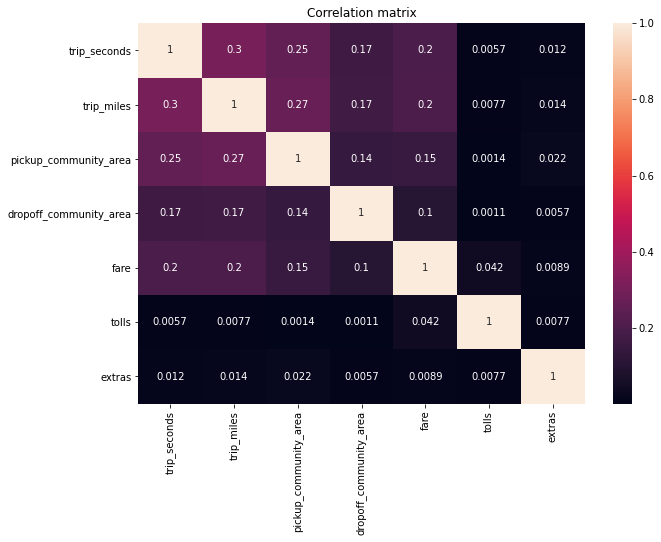

In [0]:
# Matriz de correlación para ver que no haya correlación alta entre características numéricas.
assembler = VectorAssembler(inputCols= num_cols, outputCol="cols_corr")
corrData = assembler \
  .transform(df) \
  .drop(*num_cols)

pearsonCorr = Correlation \
  .corr(corrData, 'cols_corr', 'pearson') \
  .collect()[0][0]
corrmatrix = pearsonCorr \
  .toArray() \
  .tolist()

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
  corrmatrix, 
  ax=ax, 
  annot=True, 
  xticklabels= num_cols, 
  yticklabels= num_cols
)
ax.set_title('Correlation matrix')
plt.show()

La correlación entre las variables es baja, no hay variables correlacionadas entre sí.

In [0]:
# Se ven las estadísticas de las variables numéricas.
display(df.select(num_cols).summary())

summary,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras
count,55759721,55759721,55759721,55759721,55759721,55759721,55759721
mean,793.1759659270892,2.7950331715181163,23.34304303638822,21.878517917978822,12.456398106260215,0.0011551695174371478,0.8937917632335318
stddev,1104.1871769016914,7.113920296467148,19.12471357311975,17.724078281025516,34.18342936388972,0.5139523288112883,26.457453618283253
min,0,0.0,1,1,0.0,0.0,0.0
25%,360,0.0,8,8,6.0,0.0,0.0
50%,540,1.0,24,22,8.0,0.0,0.0
75%,931,2.4,32,32,12.75,0.0,1.0
max,86399,3353.1,77,77,9900.28,1024.99,9993.41


Las medias, desvíos, máximos y mínimos son muy desparejos. Parece haber varios outliers también.

Se ve si hay registros con situaciones raras. Consideramos que un registro es outlier si:
* Tiene más de una hora de viaje pero sin millas recorridas: No tiene sentido que esté una hora el taxi parado con un pasajero sin haber ningún movimiento, salvo que haya habido algún problema al tomarse el taxi (accidente, etc.) 
* Un viaje de más de medio día sin peajes ni extras: Quizá alguien haya contratado un taxi para que lo acompañe todo el día en un recorrido, pero tiene que haber habído esperas y por lo tanto extras. 
* Si fueron de más de 500 millas sin peajes ni extras: 500 millas sería lo que un auto podría recorrer en 12 horas yendo a 60km/h que sería el máximo en una ciudad. 
* Extras mayores a 500 dólares para viajes menores a una hora: En una hora no se puede recorrer mucho como para que haya extras tan grandes.
* Tarifas de más de 5000 dólares para viajes menores a una hora: El máximo de extras y de peajes no llegan a ese número sumados, menos en una hora.

Estas condiciones podrían ser mucho más estrictas, pero habría que conocer el mercado de taxis de Nueva York para saber que situaciones son esperables o no.

In [0]:
# Viajes con más de una hora sin millas recorridas.
filter_log_trip_no_miles = (col('trip_seconds') > 3600) & (col('trip_miles') == 0)
log_trip_no_miles = df.filter(filter_log_trip_no_miles).count()
print(f'Hay {log_trip_no_miles} registros de viajes de más de una hora y 0 millas de distancia.')
df_no_log_trip_no_miles = df.filter(~ filter_log_trip_no_miles )

# Viajes de más de medio día de duración sin extras ni peajes.
filter_half_day_trip_no_extras = (col('trip_seconds') > 43200) & (col('tolls') == 0) & (col('extras') == 0)
half_day_trip_no_extras = df_no_log_trip_no_miles.filter(filter_half_day_trip_no_extras ).count()
print(f'Hay {half_day_trip_no_extras} registros de viajes de más de medio día (12 horas) y sin extras o peajes.')
df_no_half_day_trip_no_extras = df_no_log_trip_no_miles.filter(~filter_half_day_trip_no_extras)

# Viajes de más de 500 millas
filter_long_miles_trips = (col('trip_miles') > 500) & ((col('trip_seconds') == 0) | ((col('tolls') == 0) & (col('extras') == 0)))
long_miles_trips = df_no_half_day_trip_no_extras.filter(filter_long_miles_trips ).count()
print(f'Hay {long_miles_trips} registros de viajes de más de 500 millas y sin extras o peajes, o tiempo cero.')
df_no_long_trips = df_no_half_day_trip_no_extras.filter(~filter_long_miles_trips)

filter_high_extras = (col('extras') > 500) & (col('trip_seconds') < 3600)
high_extras = df_no_long_trips.filter(filter_high_extras).count()
print(f'Hay {high_extras} registros con más de 500 dolares de extra y menos de una hora de viaje.')
df_no_high_extras = df_no_long_trips.filter(~filter_high_extras)

filter_expensive = (col('fare') > 5000) & (col('trip_seconds') < 3600)
expensive = df_no_high_extras.filter(filter_expensive).count()
print(f'Hay {expensive} viajes de más de 5000 dolares que duraron menos de una hora')
df_cut = df_no_high_extras.filter(~filter_expensive)


Hay 75904 registros de viajes de más de una hora y 0 millas de distancia.
Hay 3317 registros de viajes de más de medio día (12 horas) y sin extras o peajes.
Hay 448 registros de viajes de más de 500 millas y sin extras o peajes, o tiempo cero.
Hay 2071 registros con más de 500 dolares de extra y menos de una hora de viaje.
Hay 911 viajes de más de 5000 dolares que duraron menos de una hora


Se vuelve a ver el summary para ver cómo se modificaron las variables estadísticas luego de aplicar los filtros.

Puede verse que unque se filtraron las situaciones atípicas siguen habiendo valores muy extremos.

In [0]:
display(df_cut.select(num_cols).summary())

summary,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras
count,55677070,55677070,55677070,55677070,55677070,55677070,55677070
mean,780.4814376905969,2.79083671841203,23.31442805808567,21.8557491261663,12.296918428358374,9.694879777258397E-4,0.7575371762558599
stddev,856.4009586409493,6.503680616830731,19.09112601429067,17.69283985244927,17.755188190512907,0.41463514747650687,3.5775584778522425
min,0,0.0,1,1,0.0,0.0,0.0
25%,360,0.0,8,8,6.0,0.0,0.0
50%,540,1.0,24,22,8.0,0.0,0.0
75%,917,2.4,32,32,12.75,0.0,1.0
max,86396,3353.1,77,77,9890.12,999.99,9493.94


#### Análisis para varibles categóricas.


Gráfico de barras de 'company' vs cantidad de 'tip', agrupado por si hubo o no propina, stackeado.
La mayoría de las empresas rondan el 50% de propina o no, salvo algunas pocas.

Como la función *display()* solo está disponible en databricks, se presenta una imagen de cómo se ve el gráfico en dicha plataforma, realizado con la totalidad de los datos.

![](https://github.com/NuriaSarochar/Spark/blob/main/plot_bar_taxi.png?raw=true)

In [0]:
# Keys: company, Series grouping: tip, Values: tip.
# Display Type: Bar chart, 100% stacked. Aggregation: COUNT.
# Descomentar solo en databricks 
# display(df_cut)

In [0]:
# Se agrupa por 'payment_type', con porcentaje de ocurrencia.
grouped_payment = df_cut.groupBy('payment_type').count().orderBy('count', ascending = False) \
  .withColumn('porcentaje', col('count') / df_cut.count())
print(f'Categorías distintas = {grouped_payment.count()}')

grouped_payment.show()

Categorías distintas = 11
+------------+--------+--------------------+
|payment_type|   count|          porcentaje|
+------------+--------+--------------------+
|        Cash|32388812|  0.5817262294872916|
| Credit Card|22174038| 0.39826158237134246|
|     Unknown|  304533|0.005469630496001316|
|      Prcard|  285563|0.005128915727785245|
|   No Charge|  274448|0.004929282377826276|
|      Mobile|  205887|0.003697877779847...|
|     Dispute|   35751|6.421135307587127E-4|
|       Pcard|    5543| 9.95562446084178E-5|
|       Split|    1704|3.060505877913475E-5|
|     Prepaid|     743|1.334481142775652...|
|    Way2ride|      48|8.621143318066127E-7|
+------------+--------+--------------------+



Hay dos tipo de pagos más importantes, chash y credit chard. El resto, se agrupan como 'Other'

In [0]:
df_payment_clean = df_cut.withColumn(
  'payment_type_new', 
  when(
    (col('payment_type') != 'Cash') & (col('payment_type') != 'Credit Card'), 
    'Other'
  ) \
  .otherwise(col('payment_type'))
)
# Resultado
df_payment_clean \
  .groupBy('payment_type_new').count() \
  .orderBy('count', ascending = False) \
  .withColumn('porcentaje', col('count') / df_cut.count()) \
  .show()

+----------------+--------+--------------------+
|payment_type_new|   count|          porcentaje|
+----------------+--------+--------------------+
|            Cash|32388812|  0.5817262294872916|
|     Credit Card|22174038| 0.39826158237134246|
|           Other| 1114220|0.020012188141365916|
+----------------+--------+--------------------+



In [0]:
# Se agrupa por 'company', con porcentaje de ocurrencia.
grouped_company = df_cut.groupBy('company').count().orderBy('count', ascending = False) \
  .withColumn('porcentaje', col('count') / df_cut.count())
print(f'Categorías distintas = {grouped_company.count()}')

grouped_company.show()

Categorías distintas = 151
+--------------------+--------+--------------------+
|             company|   count|          porcentaje|
+--------------------+--------+--------------------+
|Taxi Affiliation ...|19172524| 0.34435224411054677|
|Dispatch Taxi Aff...| 4975732| 0.08936770559226626|
|Blue Ribbon Taxi ...| 4601668| 0.08264924860449732|
|Chicago Carriage ...| 3662982| 0.06578977665311771|
|Choice Taxi Assoc...| 3492852| 0.06273412016832064|
|        City Service| 2273892| 0.04084072671209171|
|            Sun Taxi| 2238678|0.040208258085420084|
|    Medallion Leasin| 2117972|0.038040291990939896|
|Northwest Managem...| 1746823| 0.03137419048811297|
|Taxi Affiliation ...| 1622576|  0.0291426255009468|
|           Flash Cab| 1433125|0.025739950036882328|
|Star North Manage...| 1260175|0.022633644335091626|
|          Globe Taxi| 1039873|0.018676862844973705|
|KOAM Taxi Associa...|  932538|0.016749049474047394|
| Top Cab Affiliation|  716971|0.012877311970619143|
|Nova Taxi Affilia.

#### Variables temporales

La serie temporal como se ve en la plataforma Databricks.

![](https://github.com/NuriaSarochar/Spark/blob/main/line_plot_time.png?raw=true)

In [0]:
# Se serie temporal
# Keys: trip_start_timestamp, Values: count
# Display Type: Line Chart
df_time_grouped = df_payment_clean.groupBy('trip_start_timestamp').count()
# display(df_time_grouped) #Descomentar para ver imagen en databricks

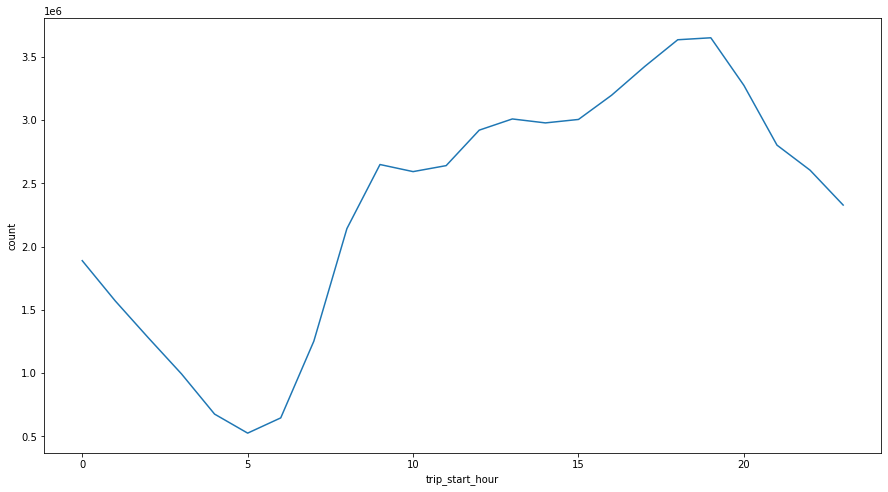

In [0]:
# Se protea la suma de ocurrencia por hora de todos los años
df_hours = df_payment_clean.withColumn('trip_start_hour', hour(col('trip_start_timestamp'))) \
  .groupBy('trip_start_hour').count().toPandas()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x = 'trip_start_hour', y = 'count', data = df_hours)
plt.show()

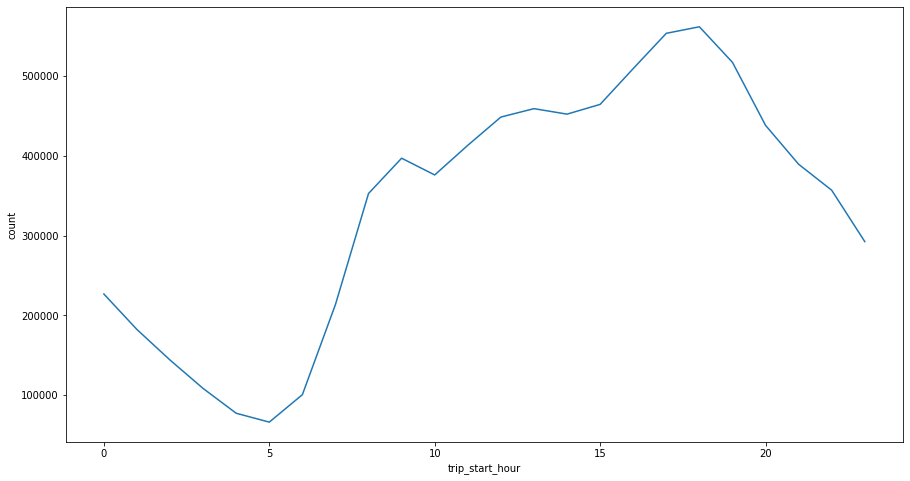

In [0]:
# Se toma un solo año, 2017.
df_2017 = df_payment_clean.filter(year(col('trip_start_timestamp')) == 2017 )
df_hours_2017 = df_2017.withColumn('trip_start_hour', hour(col('trip_start_timestamp'))) \
  .groupBy('trip_start_hour').count().toPandas()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x = 'trip_start_hour', y = 'count', data = df_hours_2017)
plt.show()

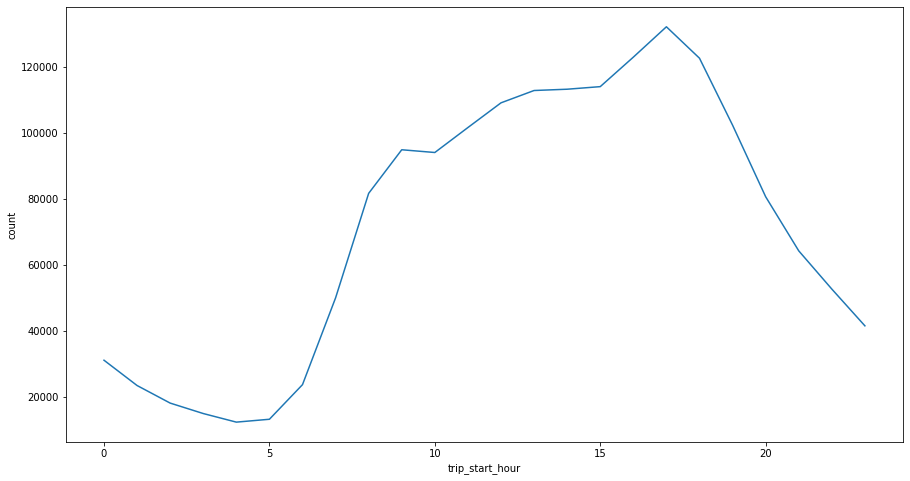

In [0]:
# Se toma el 2020
df_2020 = df_payment_clean.filter(year(col('trip_start_timestamp')) == 2020 )
df_hours_2020 = df_2020.withColumn('trip_start_hour', hour(col('trip_start_timestamp'))) \
  .groupBy('trip_start_hour').count().toPandas()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x = 'trip_start_hour', y = 'count', data = df_hours_2020)
plt.show()


Como se ve que hay una tendencia a que en ciertos momentos del día se tomen más taxis, no tiene sentido quedarse con la columna de timestamp, con toda la información de cuándo fue ese viaje. Solamente interesa en qué momento del día sucedió, a qué hora. Se genera una columna nueva con las horas de ocurrencia.
Además, la columna *tip* se castea a integer.

In [0]:
df_clean = df_payment_clean \
  .withColumn('trip_start_hour', hour(col('trip_start_timestamp'))) \
  .withColumn('label', col('tip').cast('integer'))

In [0]:
# Se chequea el tamaño del dataframe
registros = df_clean.count()
print(f'Registros: {registros}')
columnas = len(df_clean.columns)
print(f'Columnas: {columnas}')

Registros: 55677070
Columnas: 16


## Modelado

Las columnas *unique_key* y *taxi_id*, no son relevantes a la hora de hacer el modelo por ser ids.
La columna *company* tiene 151 compañias distintas, la mayoría con baja frecuencia de ocurrencia, por eso se considera que carece de significancia para el modelo.
La columna *payment_type* tiene dos categorías con mayor ocurrencia y el resto con muy baja, ellas se agrupan todas en 'Other'.
La columna *trip_start_timestamp* no tiene un patrón a lo largo de los años, pero sí todos los años cuentan con un patrón por hora. Por eso se crea una nueva columna que contiene las horas en el día, *trip_start_hour*, y *trip_start_timestamp* se descarta del modelo.

De esta manera, las features quedarán conformadas por las columnas:
* trip_seconds,
* trip_miles,
* pickup_community_area,
* dropoff_community_area,
* fare,
* tolls,
* extras,
* pyment_type_new,
* trip_start_hour.

La variable objetivo, *label*, será la columna *tip* que indica si se dejó propina o no. La misma es casteada a integer, ya que los modelos no aceptan variables booleanas.

Se va a entrenar el modelo con datos solo de los años 2013 y 2014, y estudiar si el modelo funciona bien para los años posteriores. Por lo tanto el dataset se dividirá en 4 partes:
* Años 2013 y 2014:
  * Conjunto de entrenamiento: con él se entrenarán los algoritmos.
  * Conjunto de validación: con él se evaluará la performance del algoritmo frente a datos nuevos para decidir cuál es el mejor.
  * Conjunto de testeo: con el que se testeará el algoritmo que mejor performance haya tenido con datos completamente nuevos.
* Años posteriores: se verá como perfomra el algoritmo que ajusta bien en datos de los años 2014 y 2013 con los restantes años.

In [0]:
# Para entrenar el modelo se van a usar solo los datos de los años 2013 y 2014
df_model_2013_2014 = df_clean.filter((year(col('trip_start_timestamp')) == 2013) | (year(col('trip_start_timestamp')) == 2014))

train, val, test = df_model_2013_2014.randomSplit([0.5, 0.20, 0.30], seed = 42)

train.groupBy('label').count() \
  .withColumn('porcentaje', col('count')/ train.count()).show()
# Hay un leve problema de clase desbalanceada. La métrica que se usará para evaluar los modelos será área debajo de la curva Precision-Recall

+-----+-------+------------------+
|label|  count|        porcentaje|
+-----+-------+------------------+
|    1|2140386|0.2741949058906044|
|    0|5665689|0.7258050941093955|
+-----+-------+------------------+



Se genera un pipeline de pre procesamiento, se entrena con el conjunto de train y se transforman train, val y test.

El preprocesamiento cuenta con indexación de variables categóricas y escalado de variables numéricas.

In [0]:
num_cols = ['trip_seconds', 'trip_miles', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tolls', 'extras', 'trip_start_hour']

indexer = StringIndexer(inputCol = 'payment_type_new', outputCol = 'payment_type_index')
assembler_num = VectorAssembler(inputCols = num_cols, outputCol = 'numeric_features')
scaler = StandardScaler(inputCol = 'numeric_features', outputCol = 'numeric_features_scaled')
assembler = VectorAssembler(inputCols = ['payment_type_index', 'numeric_features_scaled'], outputCol = 'features')

stages = [indexer, assembler_num, scaler, assembler]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)

# Se guardan en cache solo las variables que luego de ser transformadas varias veces van a sar utilizadas en varias futuras transformaciones.
train_pipeline = pipelineModel.transform(train).cache()
val_pipeline = pipelineModel.transform(val).cache()
test_pipeline = pipelineModel.transform(test).cache()

display(train_pipeline.select('features', 'label'))

features,label
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.6767639202995069, 0.16325467107463063, 0.44789642917254896, 0.45410780816509283, 0.625026566846636, 0.0, 0.1905262961242166, 3.2153302266236334))",0
"Map(vectorType -> sparse, length -> 9, indices -> List(1, 3, 4, 5), values -> List(0.5800833602567202, 1.7915857166901958, 1.8164312326603713, 0.5822897075750713))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.7734444803422936, 0.21767289476617419, 1.343689287517647, 1.589377328577825, 0.7318687150255482, 0.0, 0.1905262961242166, 3.2153302266236334))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.3867222401711468, 0.0952318914602012, 1.5676375021039213, 1.589377328577825, 0.4968159890319415, 0.0, 0.1905262961242166, 3.0691788526861954))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.1933611200855734, 0.06802277961442943, 0.44789642917254896, 0.45410780816509283, 0.4540791297603766, 0.0, 0.0, 2.484573356936444))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.6767639202995069, 0.0, 1.5676375021039213, 1.589377328577825, 0.6891318557539834, 0.0, 0.1905262961242166, 1.4615137393743787))",0
"Map(vectorType -> dense, length -> 9, values -> List(1.0, 0.8701250403850803, 0.24488200661194595, 0.3919093755259803, 0.283817380103183, 0.7959740039328955, 0.0, 0.0, 2.7768761048113197))",1
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.5800833602567202, 0.0, 0.44789642917254896, 0.3405808561238196, 1.0523951595622847, 0.0, 0.1905262961242166, 0.29230274787487576))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.643569520727374, 0.4217412336094625, 0.44789642917254896, 1.873194708681008, 1.2447110262843266, 0.0, 0.0, 2.338421982999006))",0
"Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.8369306408129473, 0.598600460606979, 1.62362455575049, 1.3055599484746419, 1.4583953226421509, 0.0, 0.0, 2.192270609061568))",0


In [0]:
# Generamos estas listas para poder ir guardando los resultados y luego plotear
AUC_PR_train = []
AUC_PR_val = []

Se entrena primero con un modelo de Random Forest, con hiperparámetros por defecto. 

Se evalúa con área debajo de la curva PR métrica sobre val y train.

In [0]:
RF_1 = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
modelRf_1 = RF_1.fit(train_pipeline)
predictions_train_1 = modelRf_1.transform(train_pipeline)
predictions_val_1 = modelRf_1.transform(val_pipeline)

# Evaluador
evaluator = BinaryClassificationEvaluator(labelCol = 'label', metricName = 'areaUnderPR')


AUCPR_train_1 = evaluator.evaluate(predictions_train_1)
AUCPR_val_1 = evaluator.evaluate(predictions_val_1)

AUC_PR_train.append(AUCPR_train_1)
AUC_PR_val.append(AUCPR_val_1)

print(f'El área debajo de la curva PR para el conjunto de entrenaiento es : {AUCPR_train_1}')
print('   ')
print(f'El área debajo de la curva PR para el conjunto de validación es : {AUCPR_val_1}')


El área debajo de la curva PR para el conjunto de entrenaiento es : 0.9566277256531933
   
El área debajo de la curva PR para el conjunto de validación es : 0.9568351465268888


El área debajo de la curva PR tanto para el conjunto de train y val es muy similar, eso da la pauta que es posible hacer el modelo más complejo, ya que no hay nada de overfitting. 

Por eso, se entrena un nuevo modelo con máxima profundidad en los árboles de 7.

In [0]:
RF_2 = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 7)
modelRf_2 = RF_2.fit(train_pipeline)
predictions_train_2 = modelRf_2.transform(train_pipeline)
predictions_val_2 = modelRf_2.transform(val_pipeline)


AUCPR_train_2 = evaluator.evaluate(predictions_train_2)
AUCPR_val_2 = evaluator.evaluate(predictions_val_2)

AUC_PR_train.append(AUCPR_train_2)
AUC_PR_val.append(AUCPR_val_2)

print(f'El área debajo de la curva PR para el conjunto de entrenaiento es : {AUCPR_train_2}')
print('   ')
print(f'El área debajo de la curva PR para el conjunto de validación es : {AUCPR_val_2}')

El área debajo de la curva PR para el conjunto de entrenaiento es : 0.964997715836762
   
El área debajo de la curva PR para el conjunto de validación es : 0.964661700542909


En este caso ocurre lo mismo, siguen muy pegados ambos valores. Se hace un poco más complejo. Se toman árboles de 9 de profundidad y la cantidad total de árboles es 30.

In [0]:
RF_3 = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 9, numTrees = 30)
modelRf_3 = RF_3.fit(train_pipeline)
predictions_train_3 = modelRf_3.transform(train_pipeline)
predictions_val_3 = modelRf_3.transform(val_pipeline)


AUCPR_train_3 = evaluator.evaluate(predictions_train_3)
AUCPR_val_3 = evaluator.evaluate(predictions_val_3)

AUC_PR_train.append(AUCPR_train_3)
AUC_PR_val.append(AUCPR_val_3)

print(f'El área debajo de la curva PR para el conjunto de entrenaiento es : {AUCPR_train_3}')
print('   ')
print(f'El área debajo de la curva PR para el conjunto de validación es : {AUCPR_val_3}')

El área debajo de la curva PR para el conjunto de entrenaiento es : 0.9722875635721784
   
El área debajo de la curva PR para el conjunto de validación es : 0.9725097957063751


Si se quisiera hacer un modelo más complejo se podría, pero carece de sentido ya que los tiempos de entrenamiento se alargan mucho, y el modelo no mejora lo mismo.

Probamos con un Gradient Boosted Trees.

In [0]:
GBT_1 = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)
modelGbt_1 = GBT_1.fit(train_pipeline)
predictions_train_gbt_1 = modelGbt_1.transform(train_pipeline)
predictions_val_gbt_1 = modelGbt_1.transform(val_pipeline)


AUCPR_train_gbt_1 = evaluator.evaluate(predictions_train_gbt_1)
AUCPR_val_gbt_1 = evaluator.evaluate(predictions_val_gbt_1)

AUC_PR_train.append(AUCPR_train_gbt_1)
AUC_PR_val.append(AUCPR_val_gbt_1)

print(f'El área debajo de la curva PR para el conjunto de entrenaiento es : {AUCPR_train_gbt_1}')
print('   ')
print(f'El área debajo de la curva PR para el conjunto de validación es : {AUCPR_val_gbt_1}')

El área debajo de la curva PR para el conjunto de entrenaiento es : 0.9723886882276126
   
El área debajo de la curva PR para el conjunto de validación es : 0.9727899514640982


Con la misma lógica, se hace un poco más complejo el modelo.

In [0]:
GBT_2 = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 7, stepSize = 0.1)
modelGbt_2 = GBT_2.fit(train_pipeline)
predictions_train_gbt_2 = modelGbt_2.transform(train_pipeline)
predictions_val_gbt_2 = modelGbt_2.transform(val_pipeline)


AUCPR_train_gbt_2 = evaluator.evaluate(predictions_train_gbt_2)
AUCPR_val_gbt_2 = evaluator.evaluate(predictions_val_gbt_2)

AUC_PR_train.append(AUCPR_train_gbt_2)
AUC_PR_val.append(AUCPR_val_gbt_2)

print(f'El área debajo de la curva PR para el conjunto de entrenaiento es : {AUCPR_train_gbt_2}')
print('   ')
print(f'El área debajo de la curva PR para el conjunto de validación es : {AUCPR_val_gbt_2}')

El área debajo de la curva PR para el conjunto de entrenaiento es : 0.9741147963476928
   
El área debajo de la curva PR para el conjunto de validación es : 0.9742421480494514


Out[31]: <matplotlib.legend.Legend at 0x7f41b44a9070>

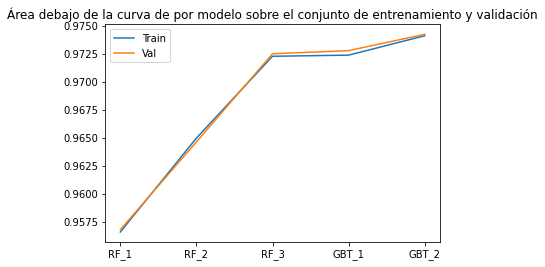

In [0]:
# Se plotean los resultados
modelos = ['RF_1', 'RF_2', 'RF_3', 'GBT_1', 'GBT_2']

plt.plot(modelos, AUC_PR_train, label = 'Train')
plt.plot(modelos, AUC_PR_val, label = 'Val')
plt.title('Área debajo de la curva de por modelo sobre el conjunto de entrenamiento y validación')
plt.legend()

Se puede ver que el mejor modelo fue el Gradient Boosted Trees con 7 de profundidad en los árboles.

Se testea cómo se comporta éste modelo con el conjunto de test.

In [0]:
predictions_test = modelGbt_2.transform(test_pipeline)
AUCPR_test = evaluator.evaluate(predictions_test)

print(f'El área debajo de la curva PR para el conjunto de testeo es : {AUCPR_test}')

El área debajo de la curva PR para el conjunto de testeo es : 0.9740102980029154


Se entrena el pipeline completo de preprocesamiento incluyendo al mejor modelo, para tener el modelo completo. El mismo se guarda. Luego se carga y se testea cómo se comporta con los otros años.

In [0]:
num_cols = ['trip_seconds', 'trip_miles', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tolls', 'extras', 'trip_start_hour']

indexer = StringIndexer(inputCol = 'payment_type_new', outputCol = 'payment_type_index')
assembler_num = VectorAssembler(inputCols = num_cols, outputCol = 'numeric_features')
scaler = StandardScaler(inputCol = 'numeric_features', outputCol = 'numeric_features_scaled')
assembler = VectorAssembler(inputCols = ['payment_type_index', 'numeric_features_scaled'], outputCol = 'features')
GBT = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 7)

stages = [indexer, assembler_num, scaler, assembler, GBT]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)


pipelinePath = '/FileStore/models/taxi_tip_model' #path donde querés guardar tu pipeline entrenada
pipelineModel.write().overwrite().save(pipelinePath)


Se carga el modelo y se aplica sobre los años restantes.

In [0]:
savedPipelineModel = PipelineModel.load('/FileStore/models/taxi_tip_model')
df_model_rest = df_clean.filter((year(col('trip_start_timestamp')) != 2013) & (year(col('trip_start_timestamp')) != 2014))
predictions = savedPipelineModel.transform(df_model_rest)

AUC = evaluator.evaluate(predictions)

print(f'El área debajo de la curva PR  para GBT para el resto de los años es : {AUC}')



El área debajo de la curva PR  para GBT para el resto de los años es : 0.9641000759346975


Se prueba por años para ver el rendimiento a largo plazo.

In [0]:
savedPipelineModel = PipelineModel.load('/FileStore/models/taxi_tip_model')
evaluator = BinaryClassificationEvaluator(labelCol = 'label', metricName = 'areaUnderPR')

In [0]:
def test_years(Year): 
  data = df_clean.filter(year(col('trip_start_timestamp')) == Year)
  predictions = savedPipelineModel.transform(data)
  AUC = evaluator.evaluate(predictions)
  print(f'El área debajo de la curva PR para el {Year} es : {AUC}')
  print('*'*10)
  return predictions, AUC


predictions_2015, AUC_2015 = test_years(2015)
predictions_2016, AUC_2016 = test_years(2016)
predictions_2017, AUC_2017 = test_years(2017)
predictions_2018, AUC_2018 = test_years(2018)
predictions_2019, AUC_2019 = test_years(2019)
predictions_2020, AUC_2020 = test_years(2020)
predictions_2021, AUC_2021 = test_years(2021)
  


El área debajo de la curva PR para el 2015 es : 0.9780636013850036
**********
El área debajo de la curva PR para el 2016 es : 0.9664044505897078
**********
El área debajo de la curva PR para el 2017 es : 0.9532869811063951
**********
El área debajo de la curva PR para el 2018 es : 0.958162615084308
**********
El área debajo de la curva PR para el 2019 es : 0.9647588097517447
**********
El área debajo de la curva PR para el 2020 es : 0.9589113902863283
**********
El área debajo de la curva PR para el 2021 es : 0.8655857575765259
**********


## Conclusiones


Se generó un modelo que predice si un viaje en taxi terminará con propina para el taxista o no. Se probaron varios modelos, de los cuales el mejor resultó ser Gradient Boosted Trees con árboles de profundida de 7 nodos. Las métricas para los conjuntos de entrenamiento y validación dieron muy bien, en razón del 0.97 de área debajo de la curva presicion-recall, siendo el máximo 1. Se eligió esta métrica ya que el problema es de clase desbalanceada, aunqueno fue necesario aplicar técnicas de balanceo. La metrica para el conjunto de test dió un valor muy similar, con lo que se puede concluir que el modelo describe bien el problema.

Luego se evaluó sobre el restante de los años y se pudo ver que el AUC sigue siendo muy bueno, 0.96. Además, se evaluo año por año para ver si era bueno el modelo y se pudo comprobar que la métrica no se modifica mucho a lo largo de los años, salvo para el 2021, aunque sigue siendo buena.